# GANs - Generative Adverserial Networks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


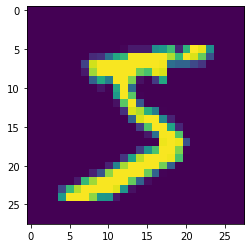

In [5]:
plt.imshow(X_train[0])
plt.show()

In [6]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Filtering out the Data for Faster Training on Smaller Dataset

In [7]:
only_zeros = X_train[y_train==0]

In [8]:
only_zeros.shape

(5923, 28, 28)

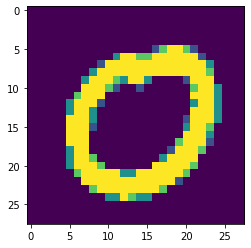

In [9]:
plt.imshow(only_zeros[950])
plt.show()

## Create the model

In [10]:
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential

We compile the discriminator, but we don't compile the generator.

In [12]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))

# final output layer
discriminator.add(Dense(1, activation='sigmoid')) # real or fake - 0 or 1

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

In [13]:
# we don't compile the generator, because it's only trained through the full GAN model
codings_size = 100

# similar as autoencoder: 784 --> 150 --> 100 --> 150 --> 784
generator = Sequential()

generator.add(Dense(100, activation='relu', input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))

generator.add(Reshape([28,28]))

In [14]:
GAN = Sequential([generator, discriminator])

In [15]:
# the discriminator shouldn't be trained during the second phase
discriminator.trainable = False

In [19]:
# layers
discriminator.layers[0].trainable

False

In [20]:
# hidden layer
discriminator.layers[1].trainable

False

In [21]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [32]:
# two sequential models
GAN.layers

In [22]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28)            143634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [23]:
# generator
GAN.layers[0].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [24]:
# discriminator
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


### Setting up Training Batches

In [25]:
batch_size = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. 

In [26]:
# change data, if you want
# my_data = X_train
my_data = only_zeros

In [27]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [28]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [31]:
my_data.shape

(5923, 28, 28)

In [29]:
# drop_remainder=True, because 5923/32 != 0
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [33]:
epochs = 1

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

## Training Loop

In [ ]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epoch
for epoch in range(epochs):
  print